In [3]:
import geopandas as gpd

import json
from shapely.geometry import shape, Point
import seaborn as sns
import numpy as np
import sympy as sp
import pandas as pd
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import random
import math
import sys
import copy

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Function to map tabular data to speed using distance between points
def RealSpeed(d,t):
    try:
        return float(d/t*3600.)
    except:
        return None

# Euclidean distance
def distance(lat1, lon1 ,lat2 , lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...  

In [4]:
class MyNode:
    def __init__(self):
        self.ID_patient=None
        self.ID_node=None
        self.st_time=None
        self.serv_time=None
        self.type_serv=None
        self.in_neighbors=[]
        self.out_neighbors=[]

    def imprimir(self):
        print("Patient ID:",self.ID_patient)
        print("st time:",self.st_time)
        print("serv time:",self.serv_time)
        print("Follow:",self.in_neighbors)
        print("Coming:",self.out_neighbors)
        print("Node ID:",self.ID_node)
    
    def imprimirLineal(self):
         print(self.ID_patient,self.st_time/3600,self.serv_time/3600)

In [6]:
def FindMiddlePoints(mus,T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols('tau_0:24')
    t=sp.Symbol('t')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    results=[int(i) for i in results]
    return results
def FindMiddlePointsSymbol(T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols(str('tau_0:')+str(T))
    t=sp.Symbol('t')
    mus=sp.symbols('u_0:24')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    #results=[int(i) for i in results]
    return results



In [8]:
mus=FindMiddlePointsSymbol(24,False)
u=sp.symbols('u_0:24')
mus[0].subs([(u[i],10*i) for i in range(24)])

-42.1286011665935

/var/folders/th/h1p304h17jq5pt71wrjdmbgr0000gn/T/ipykernel_13089/557775425.py:10: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  dictDistances=pd.DataFrame(pd.read_csv(filename,header=None))


33.47520000560799


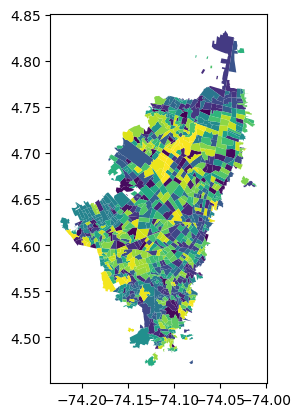

In [9]:
filename="./Input_Data/output_distances_22_8_18_1.csv"#sys.argv[1]

    
# loads csv file with travel times between pair of points
datos=pd.DataFrame(pd.read_csv("./Input_Data/bogota-cadastral-2019-3-OnlyWeekdays-HourlyAggregate.csv"))


dictDistances=pd.DataFrame(pd.read_csv(filename,header=None))
dictDistances=dictDistances.to_dict()

print(dictDistances[1][2])

data=gpd.read_file('./Input_Data/bogota_geo.json')
    
with open('./Input_Data/limites_geojson.json') as f:
	data_lims = json.load(f)   

data=data[data.scatipo.eq(0)]

data.plot(column='cartodb_id')
plt.savefig('world.pdf')


localidades=gpd.read_file('./Input_Data/Bog-poligonos-localidades.geojson')

In [10]:
posx={}
posy={}
for index, row in data.iterrows():
    try:
        posx[row['cartodb_id']],posy[row['cartodb_id']]=shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0]
    except:
        #print(row['cartodb_id'])
        pass
    #print(shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0])

In [11]:
# Adding new columns to the dataframe containg the travel times as read from Uber datafile.
datos["CoorXOrigen"]=datos["sourceid"].map(posx)
datos["CoorYOrigen"]=datos["sourceid"].map(posy)
datos["CoorXDestino"]=datos["dstid"].map(posx)
datos["CoorYDestino"]=datos["dstid"].map(posy)
datos=datos.dropna()

In [12]:
datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod, "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})

"""datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod,  , "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})"""

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


In [10]:

# Using inverse distances, seven neighbors and Manhattan (p=1) distances
neigh = KNeighborsRegressor(n_neighbors=7, weights="distance", p=1) 
X = df.iloc[:, :-1].values  # Input
y = df.iloc[:,5].values #outout

# Normalizing the input data
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)  

# "training" the model

neigh.fit(X, y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                    weights='distance')

In [11]:
# A set of points to predict travel times during the whole day (Mandalay - Las aguas)

X_new=np.array([[-74.182690,  4.596858,-74.044301, 4.68261,   i] for i in range(24)])
X_new=scaler.transform(X_new)


#print predictions
print(neigh.predict(X_new))
#print(mus)
             
proms=neigh.predict(X_new)
#print(FindMiddlePoints(proms,24,True))

u=sp.symbols('u_0:24')
for t in range(24):
    print(mus[t].subs([(u[j],i) for i,j in zip(proms,range(24))]))


[ 694.68264382  684.57471118  713.60798607  867.39364897  860.79558555
 1192.22913552 1265.2196984  1495.90090228 1256.77587446 1201.35464937
 1136.74660164  917.70472523 1344.37328958 1136.77990075 1058.22006408
 1151.35033666 1648.09674403 2285.55067692 1756.56079671 1475.99345803
 1461.23939236 1108.52559266  873.88253654  935.69601789]
643.633724287963
691.437656951842
684.337685973449
911.400200742478
786.421798344422
1256.44188554244
1212.67024289685
1590.77390752663
1210.14585058405
1202.55802617577
1185.34322842275
779.355447875905
1480.16190599129
1094.65943307525
1046.12069952731
1094.37688182842
1598.42070275317
2499.87285393282
1686.74758903326
1432.12798552682
1528.43216204853
1087.19418107781
816.607492766946
1004.22115461406


In [12]:
Matriz=np.zeros(shape=(24,24))
#vector=np.array(neigh.predict(X_new))

#print(mus)
a = sp.Poly(mus[7], u[18])
#print(a.all_coeffs()[0])
#print(mus[18])
for i in range(24):
    for j in range(24):
        a = sp.Poly(mus[i], u[j])
        #print(i,j,a.all_coeffs()[0],)
        try:
            Matriz[i,j]=a.all_coeffs()[0]
        except:
            Matriz[i,j]=0

filename="clean_Data_Tito.csv"
for size in [15,25,50,100,200]:
    for instance in range(1,6):
        Coordenadas=pd.DataFrame(pd.read_csv(filename))
        Coordenadas=Coordenadas[["lon","lat"]].sample(n=size).reset_index()
        Coordenadas["DUR"]= np.random.randint(1, 5, Coordenadas.shape[0])*15*60
        Coordenadas["SERV"]= np.random.randint(1, 2, Coordenadas.shape[0])
        Coordenadas["OPT1"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT2"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT3"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas.to_csv("./Heuristicas/new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv")

In [16]:
import gurobipy as gp

def RunModel(filename,constant=True,n_visits=3):
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    Coordenadas

    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    Model= gp.Model('netflow')
    Model.Params.timeLimit = 100.0
    x = Model.addVars(edges.keys(),  vtype=gp.GRB.BINARY, name='e')

    list_nodes=list(dict_nodes.keys())
    list_nodes+=[0,count_nodes+1]
    print(list_nodes)
    Model.addConstrs(x.sum(c,'*') == x.sum('*',c) for c in dict_nodes.keys())

    for j in Patient_nodes.keys():
        Model.addConstr(gp.quicksum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==1)

    Model.setObjectiveN(gp.quicksum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ]),0,2)
    Model.setObjectiveN(gp.quicksum([x[i,j]*edges[i,j]  for i in dict_nodes.keys() for j in dict_nodes.keys() if (i,j) in edges.keys() ]),1,1)

    Model.optimize()
    #Model.write("lookatme.lp")

#RunModel("./new_Instances/HHC_100_4.csv",False,3)

1

In [ ]:
import gurobipy as gp

def RunModelMultiSkill(filename,constant=True,n_visits=3,nskills=1):
    compat=np.array([[1,0,0],[1,1,0],[1,1,1]])
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.type_serv=min(rows["SERV"]-1,nskills-1)
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(nskills))
    
    ModBal = gp.Model('netflow')
    ModBal.Params.timeLimit = 3600.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2
    ModBal.Params.OutputFlag = 0

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K}
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time
    
    #print(undic)
    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')

    #ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  == 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j] and compat[e[2],int(dict_nodes[e[1]].type_serv)]==1])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)

    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z_max for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)
    
    ModBal.setObjectiveN(gp.quicksum([x[e]*(e[2]+1)  for e in multiEdges if e[0]==0 ]),0,2)
    ModBal.setObjectiveN(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges]),1,1)
    ModBal.optimize()
   # ModBal.write("lookatme.lp")
    
    nObjectives = ModBal.NumObj
    #print("Solution Time:",ModBal.Runtime)
    output_Excel=[filename,constant ,n_visits ,nskills, ModBal.Runtime]
    for o in range(nObjectives):
        ModBal.params.ObjNumber = o
        output_Excel.append(ModBal.ObjNVal)
    output_Excel+=[sum([x[e].X>0.5 for e in multiEdges if e[0]==0 and e[2]==k]) for k in K]
    if nskills==1:
        output_Excel+=[0,0]
    if nskills==2:
        output_Excel+=[0]
    
    nextNode={0:[]}
    for e in multiEdges:
        if x[e].X>0.5:
            if e[0]!=0:
                nextNode[e[0]]=e[1]
            else:
                 nextNode[e[0]].append(e[1])

    Rutas=[]
    for i in nextNode[0]:
        route=[0]
        route=WriteRoute(nextNode,i,route)
        Rutas.append(route)  
    #print(Rutas)
    list_cost=[]
    for ruta in Rutas:
        cost_ruta=0
        for i,j in zip(ruta, ruta[1:]):
            cost_ruta+=cost[i,j,0]+serv[i,j,0]
        list_cost.append(cost_ruta) 
    
    Factible=True
    for ruta in Rutas:
        for i,j in zip(ruta, ruta[1:]):
            if i>0 & j<count_nodes:
                t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t>=dict_nodes[j].st_time:
                    Factible=False
                    break

    output_Excel+=[np.max(list_cost),np.min(list_cost),sum(list_cost),Factible]
    
    print(output_Excel)
    return output_Excel
    #Model.write("lookatme.lp")

TablaResultados=[]
#print(RunModelMultiSkill("./new_Instances/HHC_50_1.csv",False,3,3))
for size in [15,25,50,75,100]:#,
    for instance in range(1,6):
        for constant in [False]:
            for visit in [3]:
                for skills in [1]:
                    #break
                    filename="./new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv"
                    TablaResultados.append(RunModelMultiSkill(filename,constant))
    #break
#f="./new_Instances/HHC_15_1.csv"
#RunModelMultiSkill(f,False)


./new_Instances/HHC_15_1.csv


In [97]:
np.array(TablaResultados)[:,12]


array(['44859.0', '47011.0', '44222.0', '49214.0', '46857.0', '75129.0',
       '86234.0', '91123.0', '85216.0', '81328.0', '161032.0', '145534.0',
       '153314.0', '158719.0', '161599.0', '242095.0', '233120.0',
       '245580.0', '239991.0', '235296.0', '321220.0', '327926.0',
       '326872.0', '312015.0', '314322.0'], dtype='<U29')

In [30]:
df=pd.DataFrame(np.array(TablaResultados))
df.columns=["filename","Constant","n_visits" ,"nskills", "Runtime","FO1","P1","P2","P3","Zmax","Zmin"]
df.to_csv("TablaResultados_Fase_I_100.csv")
df

,filename,Constant,n_visits,nskills,Runtime,FO1,P1,P2,P3,Zmax,Zmin
0,./new_Instances/HHC_100_1.csv,True,1,1,0.06199836730957031,20.0,20,0,0,26676.600610924448,9330.111911850598
1,./new_Instances/HHC_100_1.csv,True,1,2,0.10300064086914062,33.0,7,13,0,24940.102747591296,6666.077061403666
2,./new_Instances/HHC_100_1.csv,True,1,3,0.2049999237060547,41.0,7,5,8,25211.43182089451,8099.244071490224
3,./new_Instances/HHC_100_1.csv,True,2,1,0.3560009002685547,12.0,12,0,0,33498.690769215194,24941.818706843762
4,./new_Instances/HHC_100_1.csv,True,2,2,0.9729995727539062,21.0,5,8,0,31933.168773460275,23307.89278221255
...,...,...,...,...,...,...,...,...,...,...,...
85,./new_Instances/HHC_100_5.csv,False,2,2,5.394929885864258,20.0,4,8,0,33404.0,26855.0
86,./new_Instances/HHC_100_5.csv,False,2,3,4.379913330078125,25.0,4,3,5,33568.0,25898.0
87,./new_Instances/HHC_100_5.csv,False,3,1,1.325948715209961,11.0,11,0,0,34649.0,23385.0
88,./new_Instances/HHC_100_5.csv,False,3,2,21.81148338317871,18.0,4,7,0,33245.0,28215.0


In [89]:
import pandas as pd
res=pd.read_csv("TablaResultados_nueva.csv")
opt_basic=res[(res["Constant"]==False) & (res["n_visits"]==3) & (res["nskills"]==1)].groupby(["filename"])["FO1"].agg(min).to_dict()
opt_basic

{'./new_Instances/HHC_15_1.csv': 3.0,
 './new_Instances/HHC_15_2.csv': 2.0,
 './new_Instances/HHC_15_3.csv': 3.0,
 './new_Instances/HHC_15_4.csv': 3.0,
 './new_Instances/HHC_15_5.csv': 2.0,
 './new_Instances/HHC_25_1.csv': 3.0000000006648344,
 './new_Instances/HHC_25_2.csv': 3.0,
 './new_Instances/HHC_25_3.csv': 4.0,
 './new_Instances/HHC_25_4.csv': 4.0,
 './new_Instances/HHC_25_5.csv': 3.0,
 './new_Instances/HHC_50_1.csv': 6.0,
 './new_Instances/HHC_50_2.csv': 6.0,
 './new_Instances/HHC_50_3.csv': 6.0,
 './new_Instances/HHC_50_4.csv': 6.0,
 './new_Instances/HHC_50_5.csv': 6.0,
 './new_Instances/HHC_75_1.csv': 9.0,
 './new_Instances/HHC_75_2.csv': 8.0,
 './new_Instances/HHC_75_3.csv': 9.0,
 './new_Instances/HHC_75_4.csv': 9.0,
 './new_Instances/HHC_75_5.csv': 9.0}

In [90]:
Coordenadas=pd.DataFrame(pd.read_csv("./new_Instances/HHC_15_1.csv"))
Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
Coordenadas

,lon,lat,DUR,SERV,OPT1,OPT2,OPT3
0,-74.151374,4.603810,1800,1,50400,57600,25200
1,-74.071635,4.611416,900,3,34200,36000,46800
2,-74.071000,4.656725,900,1,59400,57600,50400
3,-74.059037,4.650061,900,2,59400,34200,37800
4,-74.077465,4.670745,900,3,37800,57600,36000
5,-74.150780,4.621167,3600,2,36000,28800,36000
6,-74.069172,4.716945,3600,1,36000,34200,27000
7,-74.145904,4.565813,2700,2,27000,46800,39600
8,-74.127386,4.682290,2700,1,46800,43200,55800
9,-74.138184,4.623661,1800,3,27000,28800,25200


In [15]:
dict_locaciones={}
for iter,rows in Coordenadas.iterrows():
    for iter2,rows2 in Coordenadas.iterrows():
        if iter!=iter2:
            X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
            X_new=scaler.transform(X_new)
            proms=np.array(neigh.predict(X_new))
            dict_locaciones[iter,iter2]=Matriz.dot(proms)

NameError: name 'Coordenadas' is not defined

In [82]:
horas=[(0.5+i)*3600 for i in range(24)]
count_nodes=0
dict_nodes={}
edges={}
Patient_nodes={}

for iter,rows in Coordenadas.iterrows():
    listnodes=[]
    for node in range(1):
        col_name="OPT"+str(node+1)
        count_nodes+=1
        x = MyNode()
        x.ID_patient=iter
        x.serv_time=rows["DUR"]
        x.ID_node=count_nodes
        x.st_time=rows[col_name]
        dict_nodes[x.ID_node]=x
        listnodes.append(x.ID_node)
    Patient_nodes[iter]=listnodes

for i in dict_nodes.keys():
    for j in dict_nodes.keys():
        if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
            #t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
            t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
            if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                edges[i,j]=t

for i in range(1,count_nodes+1):
    edges[0,i]=0
    edges[i,count_nodes+1]=0
    
SortedNodes=[]
for i in np.sort(list(dict_nodes.keys())):
    SortedNodes.append(dict_nodes[i].st_time)

SortedNodes=np.argsort(SortedNodes)+1
#print(np.where(SortedNodes == 15)[0][0])

In [83]:
X=[1,6,2,4,9]
Y=[dict_nodes[i].st_time for i in X]
print(Y)
[x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]

[50400.0, 36000.0, 34200.0, 59400.0, 46800.0]


[2, 6, 9, 1, 4]

In [84]:
import folium
import datetime

mapa = folium.Map(location=[4.60971, -74.08175], zoom_start = 11)

points = []
for iter,rows in Coordenadas.iterrows():
    points.append((rows["lat"],rows["lon"]))
    folium.Marker( (rows["lat"],rows["lon"]),popup='{0:02.0f}:{1:02.0f}'.format(*divmod(float(rows["OPT1"]/3600) * 60, 60))).add_to(mapa)
points.append(points[0])

#folium.PolyLine(points).add_to(map)



mapa

In [85]:
import gurobipy as gp
Model= gp.Model('netflow')
Model.Params.timeLimit = 100.0
x = Model.addVars(edges.keys(),  vtype=gp.GRB.BINARY, name='e')

list_nodes=list(dict_nodes.keys())
list_nodes+=[0,count_nodes+1]
print(list_nodes)
Model.addConstrs(x.sum(c,'*') == x.sum('*',c) for c in dict_nodes.keys())

for j in Patient_nodes.keys():
    Model.addConstr(gp.quicksum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==1)


Model.setObjectiveN(gp.quicksum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ]),0,2)
Model.setObjectiveN(gp.quicksum([x[i,j]*edges[i,j]  for i in dict_nodes.keys() for j in dict_nodes.keys() if (i,j) in edges.keys() ]),1,1)

Model.optimize()
Model.write("lookatme.lp")

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 0, 16]
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 30 rows, 116 columns and 303 nonzeros
Model fingerprint: 0x9bdc6dcf
Variable types: 0 continuous, 116 integer (116 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 5 rows and 5 columns
Presolve time: 0.00s
Presolved: 25 rows and 111 columns
----------------------------------------------------

In [21]:
def WriteRoute(Next,init,route):
    route.append(init)
    if Next[init] in Next.keys():
        
        return WriteRoute(Next,Next[init],route)
    else:
        return route

In [21]:
nextNode={0:[]}
for e in edges:
    if x[e].X>0.5:
        #print(e[0],e[1],x[e].X)
        if e[0]!=0:
            nextNode[e[0]]=e[1]
        else:
             nextNode[e[0]].append(e[1])

print(nextNode,len(nextNode.keys()))
Rutas=[]
for i in nextNode[0]:
    route=[0]
    route=WriteRoute(nextNode,i,route)
    Rutas.append(route)


print(Rutas)

NameError: name 'edges' is not defined

In [ ]:
nObjectives = Model.NumObj
nSolutions  = Model.SolCount

print('Problem has', nObjectives, 'objectives')
print('Gurobi found', nSolutions, 'solutions')

for o in range(nObjectives):
    # Set which objective we will query
    Model.params.ObjNumber = o
    # Query the o-th objective value
    print(' ',Model.ObjNVal, end='')

In [ ]:
#Callback - use lazy constraints to eliminate sub-tours
def BenderCuts3(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        yvals = model.cbGetSolution(model._vars)
        K=model._K
        z_max=model._z_max
        cost=ModBal._cost
        selected = gp.tuplelist((i, k) for i, k in model._vars.keys() if yvals[i, k] > 0.9)

        for k in model._K:            
            X=[n[0] for n in selected if n[1]==k]
            Y=[dict_nodes[i].st_time for i in X]
            nodesChosen=[x for _, x in sorted(zip(Y,X), key=lambda pair: pair[0])]
            
            bound=0
            Factible=True
            
            for i,j in zip(nodesChosen,nodesChosen[1:]):
                if (i, j, k) not in model._edges:
                    expr2=1+gp.quicksum(model._vars[model._sorted[l], k] for l in range(np.where(model._sorted==i)[0][0]+1,np.where(model._sorted==j)[0][0]-1))
                    expr1=model._vars[i, k] + model._vars[j, k]
                    model.cbLazy( expr1<=expr2)
                    Factible=False            
                if not Factible:
                    break
            if Factible:
                for k2 in model._K:
                    model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )<=z_max)
                   #model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]+model._serv[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )>=z_min)
                    #model.cbLazy( gp.quicksum((model._vars[i, k2] + model._vars[j, k2]-1)*(model._cost[i,j,k2]) for i,j in zip(nodesChosen,nodesChosen[1:]) )<=z)
            if not Factible:
                break

In [31]:
def RunModelBalance(filename,npersons,constant=False,n_visits=3):
    import gurobipy as gp
    
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(npersons))#range(int(nskills))

    ModBal= gp.Model('netflow')
    ModBal.Params.timeLimit = 1800.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K}
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time

    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')
    z=ModBal.addVars(K, name='z')
    z_max=ModBal.addVar(obj=1,name='z_max')


    ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  <= 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j]])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)



    ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  == z[k] for k in K)
    ModBal.addConstrs( z_max >= z[k] for k in K)
    #ModBal.addConstrs( z[k+1] >= z[k] for k in range(len(K)-1))
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)

    ModBal.optimize()
    zs=[z[k].X for k in K]
    return [filename,np.min(zs),np.max(zs),sum(zs),ModBal.Runtime]


#TablaBalance=[]
#for f,n in opt_basic.items():
#    TablaBalance.append(RunModelBalance(f,n,constant=False))

In [ ]:
ejercicios={
{'./new_Instances/HHC_15_1.csv': 3.0,
 './new_Instances/HHC_15_2.csv': 2.0,
 './new_Instances/HHC_15_3.csv': 3.0,
 './new_Instances/HHC_15_4.csv': 3.0,
 './new_Instances/HHC_15_5.csv': 2.0,
 './new_Instances/HHC_25_1.csv': 3.0,
 './new_Instances/HHC_25_2.csv': 3.0,
 './new_Instances/HHC_25_3.csv': 4.0,
 './new_Instances/HHC_25_4.csv': 4.0,
 './new_Instances/HHC_25_5.csv': 3.0,
 './new_Instances/HHC_50_1.csv': 6.0,
 './new_Instances/HHC_50_2.csv': 6.0,
 './new_Instances/HHC_50_3.csv': 6.0,
 './new_Instances/HHC_50_4.csv': 6.0,
 './new_Instances/HHC_50_5.csv': 6.0,
 './new_Instances/HHC_75_1.csv': 9.0,
 './new_Instances/HHC_75_2.csv': 8.0,
 './new_Instances/HHC_75_3.csv': 9.0,
 './new_Instances/HHC_75_4.csv': 9.0,
 './new_Instances/HHC_75_5.csv': 9.0
}

TablaAgosto2=[]
for f in ejercicios.keys():
    try:
        TablaAgosto2.append(RunModelBalance(f,ejercicios[f],constant=False))
    except:
        pass

./new_Instances/HHC_25_3.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 337 rows, 8889 columns and 34648 nonzeros
Model fingerprint: 0x28088848
Variable types: 5 continuous, 8884 integer (8884 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 24 rows and 304 columns
Presolve time: 0.29s
Presolved: 313 rows, 8585 columns, 32256 nonzeros
Variable types: 0 continuous, 8585 integer (8580 binary)
Presolved: 313 rows, 8585 columns, 32256 nonzeros


Root relaxation: objective 2.278075e+04, 2135 iterations, 0.28 seconds

    Nodes    |    Current Node    |     Objective Boun

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 351, in flush
    if not evt.wait(self.flush_timeout):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 300, in wait
    gotit = waiter.acquire(True, timeout)
KeyboardInterrupt: 


  3669   992 23060.2749   92   75 23480.0000 22855.0000  2.66%   134  143s
  3792  1027 23100.0000  112   70 23480.0000 22855.0000  2.66%   133  147s
  3898  1071 23116.0000  133   78 23480.0000 22855.0000  2.66%   133  152s
  3986  1101 23158.0000  157   79 23480.0000 22855.0000  2.66%   135  156s
  4083  1157 23233.8791  174   73 23480.0000 22855.0000  2.66%   138  161s
  4196  1202 23290.0000  194   76 23480.0000 22855.0000  2.66%   139  165s
  4313  1254 23317.0000  215   61 23480.0000 22855.0000  2.66%   141  170s
  4443  1311 23402.0000  242   68 23480.0000 22885.0000  2.53%   142  176s
  4572  1365 22928.0000   26  106 23480.0000 22885.0000  2.53%   143  181s
  4669  1422 23008.2141   36  101 23480.0000 22885.0000  2.53%   144  187s
  4790  1479 23107.3312   49   99 23480.0000 22885.0000  2.53%   146  193s
  4924  1493 23191.6377   62   99 23480.0000 22885.0000  2.53%   146  200s
  4955  1669 23156.0000   68   88 23480.0000 22885.0000  2.53%   147  207s
  5200  1962 23342.0841  

In [19]:
pd.DataFrame(np.array(TablaBalance)).to_csv("TablaBalance.csv")

In [8]:
import seaborn as sns
sns.set()

In [9]:
df=pd.read_csv("TablaResultados.csv")
df["Patients"]=df["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
df["Patients"]=df["Patients"].str.split("_", expand = True)
df["Patients"]=df["Patients"].apply(lambda x: int(x))
df["TotPerPatient"]=df["FO2"]/df["Patients"]
df["CostPerPatient"]=df["FO1"]/df["Patients"]*50


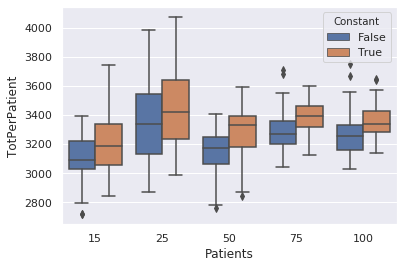

In [10]:
sns.boxplot(x="Patients",y="TotPerPatient",hue="Constant",data=df)

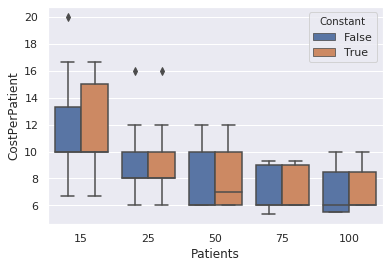

In [11]:
sns.boxplot(x="Patients",y="CostPerPatient",hue="Constant",data=df[df["nskills"]==1])

In [12]:
df["filename"].str.replace("./new_Instances/HHC_"," ").spl


AttributeError: 'Series' object has no attribute 'spl'

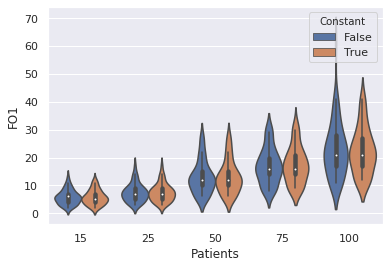

In [14]:
sns.violinplot(x="Patients",y="FO1",hue="Constant",data=df)

In [15]:
sns.boxplot(x="Patients",y="TotalTime",hue="Constant",data=df)

ValueError: Could not interpret input 'TotalTime'

In [73]:
Balancing=pd.concat([pd.read_csv("TablaBalance.csv")])
Balancing.columns=["unnamed:0:","filename","Zmin","Zmax","FO2","Runtime"]
Balancing["Zmax/Zmin"]=Balancing["Zmax"]/Balancing["Zmin"]
Balancing

,unnamed:0:,filename,Zmin,Zmax,FO2,Runtime,Zmax/Zmin
0,0,./new_Instances/HHC_100_1.csv,14036.0,39914.0,404178.0,1808.341803,2.843688
1,1,./new_Instances/HHC_100_2.csv,14301.0,31194.0,321543.0,1800.071543,2.181246
2,2,./new_Instances/HHC_100_3.csv,14175.0,28961.0,284243.0,1800.058908,2.043104
3,3,./new_Instances/HHC_100_4.csv,13641.0,27862.0,257196.0,1800.461481,2.042519
4,4,./new_Instances/HHC_100_5.csv,12691.0,34021.0,332608.0,1800.249166,2.680719
5,5,./new_Instances/HHC_15_1.csv,9555.0,10743.0,30814.0,1.798002,1.124333
6,6,./new_Instances/HHC_15_2.csv,12345.0,36119.0,48464.0,0.386002,2.925800
7,7,./new_Instances/HHC_15_3.csv,9039.0,15692.0,38251.0,20.614927,1.736033
8,8,./new_Instances/HHC_15_4.csv,11659.0,16286.0,41814.0,75.733934,1.396861
9,9,./new_Instances/HHC_15_5.csv,11942.0,28693.0,40635.0,0.121956,2.402696


In [26]:
Dimensioning=pd.concat([pd.DataFrame(pd.read_csv("TablaResultados_Fase_I.csv")),pd.DataFrame(pd.read_csv("TablaResultados_Fase_I_100.csv"))])
Dimensioning

,Unnamed: 0,filename,Constant,n_visits,nskills,Runtime,FO1,P1,P2,P3,Zmax,Zmin
0,0,./new_Instances/HHC_15_1.csv,True,1,1,0.010649,5.0,5,0,0,11601.605145,6297.184345
1,1,./new_Instances/HHC_15_1.csv,True,1,2,0.017921,7.0,3,2,0,13977.945250,5910.769339
2,2,./new_Instances/HHC_15_1.csv,True,1,3,0.019804,8.0,3,1,1,14820.704757,3600.000000
3,3,./new_Instances/HHC_15_1.csv,True,2,1,0.026131,3.0,3,0,0,23789.671947,6510.323133
4,4,./new_Instances/HHC_15_1.csv,True,2,2,0.049322,5.0,1,2,0,23599.293772,13349.600190
...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,./new_Instances/HHC_100_5.csv,False,2,2,5.394930,20.0,4,8,0,33404.000000,26855.000000
86,86,./new_Instances/HHC_100_5.csv,False,2,3,4.379913,25.0,4,3,5,33568.000000,25898.000000
87,87,./new_Instances/HHC_100_5.csv,False,3,1,1.325949,11.0,11,0,0,34649.000000,23385.000000
88,88,./new_Instances/HHC_100_5.csv,False,3,2,21.811483,18.0,4,7,0,33245.000000,28215.000000


In [38]:
Dimensioning["Patients"]=Dimensioning["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
Dimensioning["Patients"]=Dimensioning["Patients"].str.split("_", expand = True)
Dimensioning["Patients"]=Dimensioning["Patients"].apply(lambda x: int(x))

In [39]:
new=Dimensioning[["Patients","Constant","n_visits","nskills","Runtime","Zmax","Zmin","FO1"]]
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new["Constant"]=new["Constant"].apply(lambda x: "Constant" if x else "Varying")
new=new.rename(columns={"Constant": "Travel Time"})

/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [47]:
pd.DataFrame(new[new.Runtime<3500].pivot_table(index=['Patients',"n_visits"], columns='nskills', values='Runtime',aggfunc=np.mean)).round(2)#.to_latex("Tab1.tex",multicolumn = True, multirow = True)

nskills               1       2       3
Patients n_visits                      
15       1         0.01    0.01    0.01
         2         0.02    0.06    0.13
         3         0.05    0.12    0.32
25       1         0.01    0.01    0.02
         2         0.04    0.07    0.16
         3         0.07    0.38    1.03
50       1         0.02    0.03    0.05
         2         0.08    0.44    1.29
         3         0.20    0.64    4.63
75       1         0.03    0.06    0.11
         2         0.21    1.06    5.14
         3         0.52  292.19    7.57
100      1         0.05    0.11    0.22
         2         0.43    2.50   35.76
         3         1.31  126.20  281.49

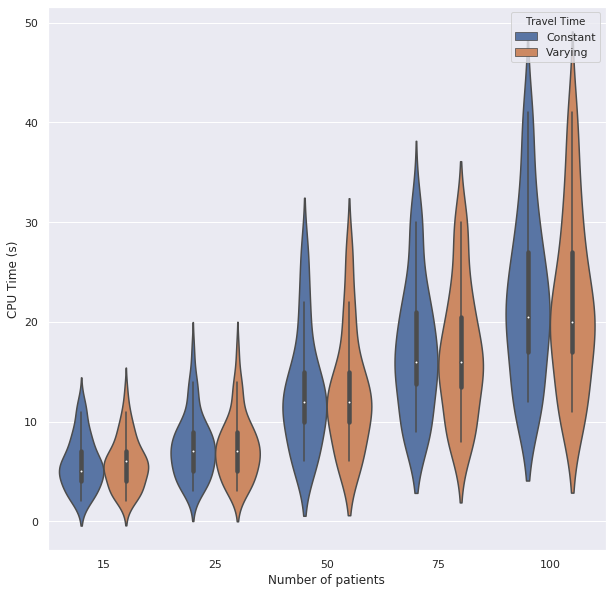

In [48]:
plt.figure(figsize=(10,10))
ax =sns.violinplot(x="Patients",y="FO1",hue="Travel Time",data=new[new.Runtime<3000])
ax.set(xlabel='Number of patients', ylabel='CPU Time (s)')
plt.savefig("myfig.png")

In [49]:
new

,Patients,Travel Time,n_visits,nskills,Runtime,Zmax,Zmin,FO1,Zmax/Zmin,FO1/Patients
0,15,Constant,1,1,0.010649,11601.605145,6297.184345,5.0,1.842348,16.666667
1,15,Constant,1,2,0.017921,13977.945250,5910.769339,7.0,2.364827,23.333333
2,15,Constant,1,3,0.019804,14820.704757,3600.000000,8.0,4.116862,26.666667
3,15,Constant,2,1,0.026131,23789.671947,6510.323133,3.0,3.654146,10.000000
4,15,Constant,2,2,0.049322,23599.293772,13349.600190,5.0,1.767790,16.666667
...,...,...,...,...,...,...,...,...,...,...
85,100,Varying,2,2,5.394930,33404.000000,26855.000000,20.0,1.243865,10.000000
86,100,Varying,2,3,4.379913,33568.000000,25898.000000,25.0,1.296162,12.500000
87,100,Varying,3,1,1.325949,34649.000000,23385.000000,11.0,1.481676,5.500000
88,100,Varying,3,2,21.811483,33245.000000,28215.000000,18.0,1.178274,9.000000


In [46]:

#new=new[["Patients","Constant","n_visits","nskills","Runtime","Zmax","Zmin","FO1"]]
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new=new.rename(columns={"Constant": "Travel Time"})
pd.DataFrame(new.pivot_table(index=['Patients',"n_visits"], columns='Travel Time', values='FO1',aggfunc=np.mean)).round(2)#.to_latex("Tab2.tex",multicolumn = True, multirow = True)

Travel Time        Constant  Varying
Patients n_visits                   
15       1             7.93     7.80
         2             5.27     5.27
         3             4.27     4.53
25       1            10.07    10.07
         2             6.67     6.67
         3             5.80     5.67
50       1            18.33    18.20
         2            11.00    10.87
         3             9.87     9.80
75       1            22.47    22.20
         2            15.27    14.87
         3            14.27    14.13
100      1            29.20    29.13
         2            19.47    19.27
         3            18.73    17.93

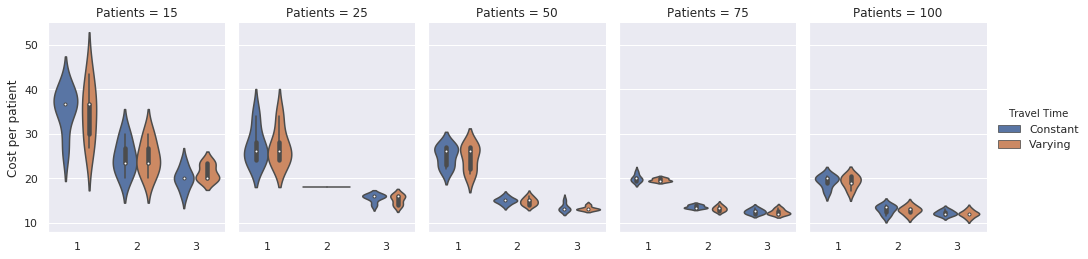

In [178]:
              
g = sns.catplot(x="Slots", y='FO1/Patients',
                hue="Travel Time", col="Patients",
                data=new[new.Skills==3], kind="violin",
                height=4, aspect=.7);
g.set_axis_labels("", "Cost per patient")
plt.savefig("MyFig_2.png")

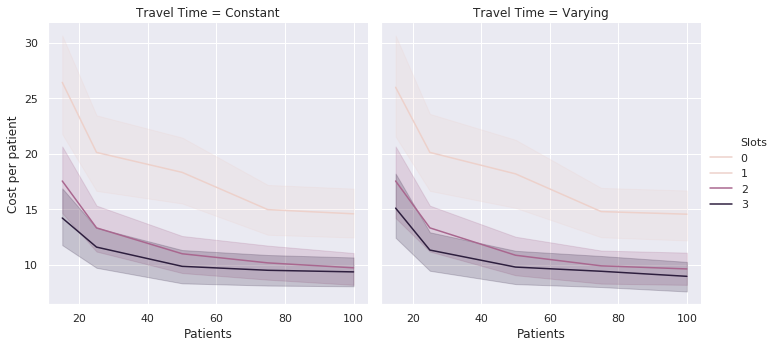

In [177]:

new.rename(columns={'nskills':'Skills',"n_visits":"Slots"},inplace=True)
g = sns.relplot(x="Patients",y='FO1/Patients',hue="Slots",col="Travel Time",kind="line",data=new)
g.set_axis_labels("Patients", "Cost per patient")
plt.savefig("MyFig_3.png")

In [161]:
new.n_visits.unique()

AttributeError: 'DataFrame' object has no attribute 'n_visits'

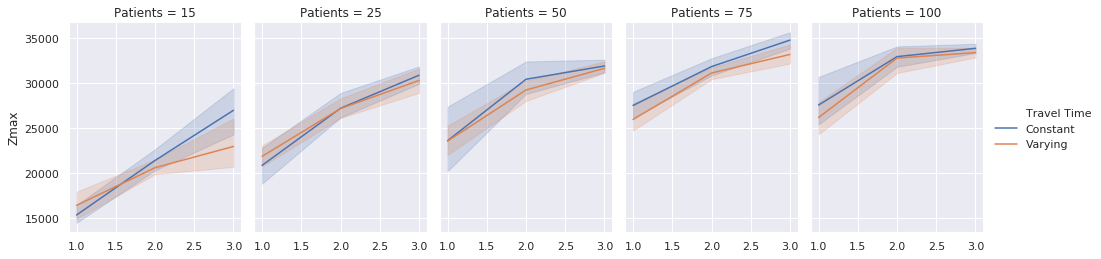

In [166]:
g = sns.relplot(x="Slots", y="Zmax",
                hue="Travel Time", col="Patients",
                data=new[new.Skills==3], kind="line",
                height=4, aspect=.7);
g.set_axis_labels("", "Zmax")
plt.savefig("MyFig_4.png")

/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


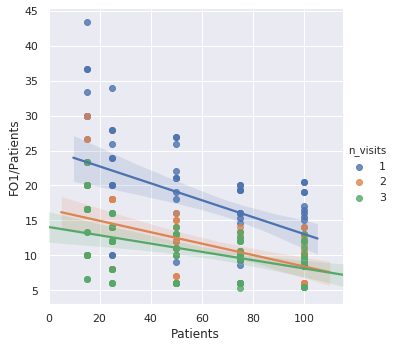

In [56]:
sns.lmplot(x="Patients",y='FO1/Patients',hue="n_visits",data=new[~df.Constant])

/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


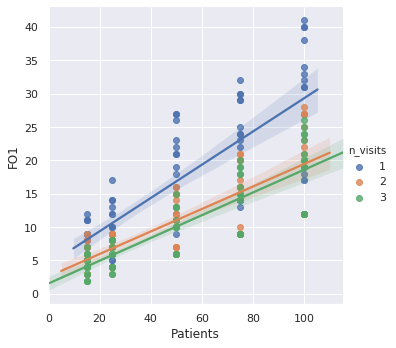

In [23]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[~df.Constant==False])

/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


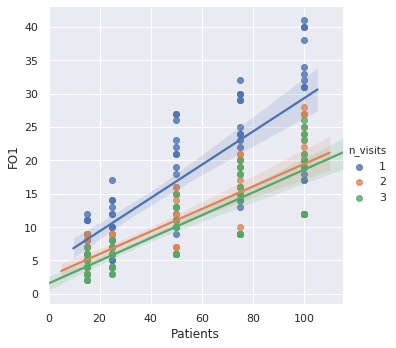

In [58]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[df.Constant])

/home/fabian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


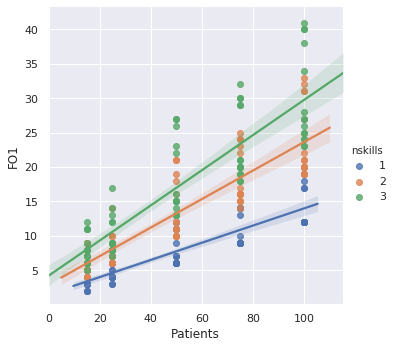

In [59]:
sns.lmplot(x="Patients",y="FO1",hue="nskills",data=Dimensioning[df.Constant])

In [75]:
Balancing

,unnamed:0:,filename,Zmin,Zmax,FO2,Runtime,Zmax/Zmin
0,0,./new_Instances/HHC_100_1.csv,14036.0,39914.0,404178.0,1808.341803,2.843688
1,1,./new_Instances/HHC_100_2.csv,14301.0,31194.0,321543.0,1800.071543,2.181246
2,2,./new_Instances/HHC_100_3.csv,14175.0,28961.0,284243.0,1800.058908,2.043104
3,3,./new_Instances/HHC_100_4.csv,13641.0,27862.0,257196.0,1800.461481,2.042519
4,4,./new_Instances/HHC_100_5.csv,12691.0,34021.0,332608.0,1800.249166,2.680719
5,5,./new_Instances/HHC_15_1.csv,9555.0,10743.0,30814.0,1.798002,1.124333
6,6,./new_Instances/HHC_15_2.csv,12345.0,36119.0,48464.0,0.386002,2.925800
7,7,./new_Instances/HHC_15_3.csv,9039.0,15692.0,38251.0,20.614927,1.736033
8,8,./new_Instances/HHC_15_4.csv,11659.0,16286.0,41814.0,75.733934,1.396861
9,9,./new_Instances/HHC_15_5.csv,11942.0,28693.0,40635.0,0.121956,2.402696


In [3]:
test=pd.DataFrame(pd.read_csv("TablaResultados_nueva.csv"))
test=test[(~test["Constant"]) & (test.n_visits==3) & (test.nskills==1)]
test["Zmax/Zmin"]=test["Zmax"]/test["Zmin"]
#((np.mean(test["Zmax/Zmin"])-np.mean(Balancing["Zmax/Zmin"])))/np.mean(Balancing["Zmax/Zmin"])

In [4]:
test

,Unnamed: 0,filename,Constant,n_visits,nskills,Runtime,FO1,FO2,P1,P2,P3,Zmax,Zmin,Zmax/Zmin
15,15,./new_Instances/HHC_15_1.csv,False,3,1,0.147430,3.0,44859.000000,3,0,0,15740.0,14521.0,1.083947
33,33,./new_Instances/HHC_15_2.csv,False,3,1,0.209995,2.0,47011.000000,2,0,0,25311.0,21700.0,1.166406
51,51,./new_Instances/HHC_15_3.csv,False,3,1,0.099901,3.0,44222.000000,3,0,0,16526.0,13226.0,1.249509
69,69,./new_Instances/HHC_15_4.csv,False,3,1,0.103895,3.0,49214.000000,3,0,0,18081.0,13786.0,1.311548
87,87,./new_Instances/HHC_15_5.csv,False,3,1,0.103313,2.0,46857.000000,2,0,0,24692.0,22165.0,1.114009
105,105,./new_Instances/HHC_25_1.csv,False,3,1,0.302299,3.0,75128.999795,3,0,0,30247.0,21154.0,1.429848
123,123,./new_Instances/HHC_25_2.csv,False,3,1,0.145514,3.0,86234.000000,3,0,0,30977.0,25812.0,1.200101
141,141,./new_Instances/HHC_25_3.csv,False,3,1,0.079645,4.0,91123.000000,4,0,0,28354.0,17515.0,1.618841
159,159,./new_Instances/HHC_25_4.csv,False,3,1,0.078648,4.0,85216.000000,4,0,0,26884.0,14445.0,1.861128
177,177,./new_Instances/HHC_25_5.csv,False,3,1,0.109564,3.0,81328.000000,3,0,0,28545.0,25808.0,1.106052
